In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt

In [5]:
# Load Data
op = 0 # 0: Local, 1: Kaggle

if not op: # Local
    train_path = './data/train.csv'
    test_path = './data/test.csv'
    sub_path = './data/sample_submission.csv'
    save_path = './data/submission.csv'
else:  # Kaggle
    train_path = '/kaggle/input/playground-series-s5e4/train.csv'
    test_path = '/kaggle/input/playground-series-s5e4/test.csv'
    sub_path = '/kaggle/input/playground-series-s5e4/sample_submission.csv'    
    save_path = '/kaggle/working/submission.csv'
    

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sub = pd.read_csv(sub_path)


# Check NaN
print(df_train.isnull().sum())
print("=====================================")
print(df_test.isnull().sum())

df_train.head()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64
id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [6]:
# Check the type of string data
comparion_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

for col in comparion_cols:
    re = np.array_equal(
        np.sort(df_train[col].unique()), 
        np.sort(df_test[col].unique())
    )
    print(f"{col} : {re}")

Podcast_Name : True
Genre : True
Publication_Day : True
Publication_Time : True
Episode_Sentiment : True


In [7]:
# Drop Feature 
drop_cols = ['Episode_Title']
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

# Fill NaN
def fill_NaN(df, target_col, group_col, method):
    df[target_col] = df[target_col].fillna(df.groupby(group_col)[target_col].transform(method))

nan_list = [
    ['Episode_Length_minutes','Podcast_Name','mean'],
    ['Number_of_Ads', 'Podcast_Name','mean'], 
    ['Guest_Popularity_percentage', 'Podcast_Name','mean']
]

for l in nan_list:
    fill_NaN(df_train, l[0], l[1], l[2])
    fill_NaN(df_test, l[0], l[1], l[2])


print(df_train.isnull().sum())
print("=====================================")
print(df_test.isnull().sum())
df_train.head()

id                             0
Podcast_Name                   0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64
id                             0
Podcast_Name                   0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64


,id,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,64.388461,True Crime,74.81,Thursday,Night,52.241037,0.0,Positive,31.41998
1,1,Joke Junction,119.800000,Comedy,66.95,Saturday,Afternoon,75.950000,2.0,Negative,88.01241
2,2,Study Sessions,73.900000,Education,69.97,Tuesday,Evening,8.970000,0.0,Negative,44.92531
3,3,Digital Digest,67.170000,Technology,57.22,Monday,Morning,78.700000,2.0,Positive,46.27824
4,4,Mind & Body,110.510000,Health,80.07,Monday,Afternoon,58.680000,3.0,Neutral,75.61031


In [8]:
# Encoding - One-hot
onehot_cols = ['Podcast_Name', 'Genre', 'Publication_Time', 'Publication_Day', 'Episode_Sentiment']
df_train = pd.get_dummies(df_train, columns=onehot_cols, drop_first=False)
df_test = pd.get_dummies(df_test, columns=onehot_cols, drop_first=False)
df_train, df_test = df_train.align(df_test, join='left', axis=1, fill_value=0)

print(df_train.columns.size == df_test.columns.size)
df_train

True


,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Podcast_Name_Athlete's Arena,Podcast_Name_Brain Boost,Podcast_Name_Business Briefs,Podcast_Name_Business Insights,...,Publication_Day_Friday,Publication_Day_Monday,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Episode_Sentiment_Negative,Episode_Sentiment_Neutral,Episode_Sentiment_Positive
0,0,64.388461,74.81,52.241037,0.0,31.41998,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1,1,119.800000,66.95,75.950000,2.0,88.01241,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,2,73.900000,69.97,8.970000,0.0,44.92531,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
3,3,67.170000,57.22,78.700000,2.0,46.27824,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
4,4,110.510000,80.07,58.680000,3.0,75.61031,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,75.660000,69.36,52.431959,0.0,56.87058,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
749996,749996,75.750000,35.21,51.273843,2.0,45.46242,False,False,True,False,...,False,False,True,False,False,False,False,False,True,False
749997,749997,30.980000,78.58,84.890000,0.0,15.26000,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
749998,749998,108.980000,45.39,93.270000,0.0,100.72939,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


In [9]:
# split Train and Val
X = df_train.drop(columns=['Listening_Time_minutes','id']).to_numpy()
y = df_train['Listening_Time_minutes'].to_numpy()
X_pred = df_test.drop(columns=['Listening_Time_minutes','id']).to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(600000, 76) (150000, 76) (600000,) (150000,)


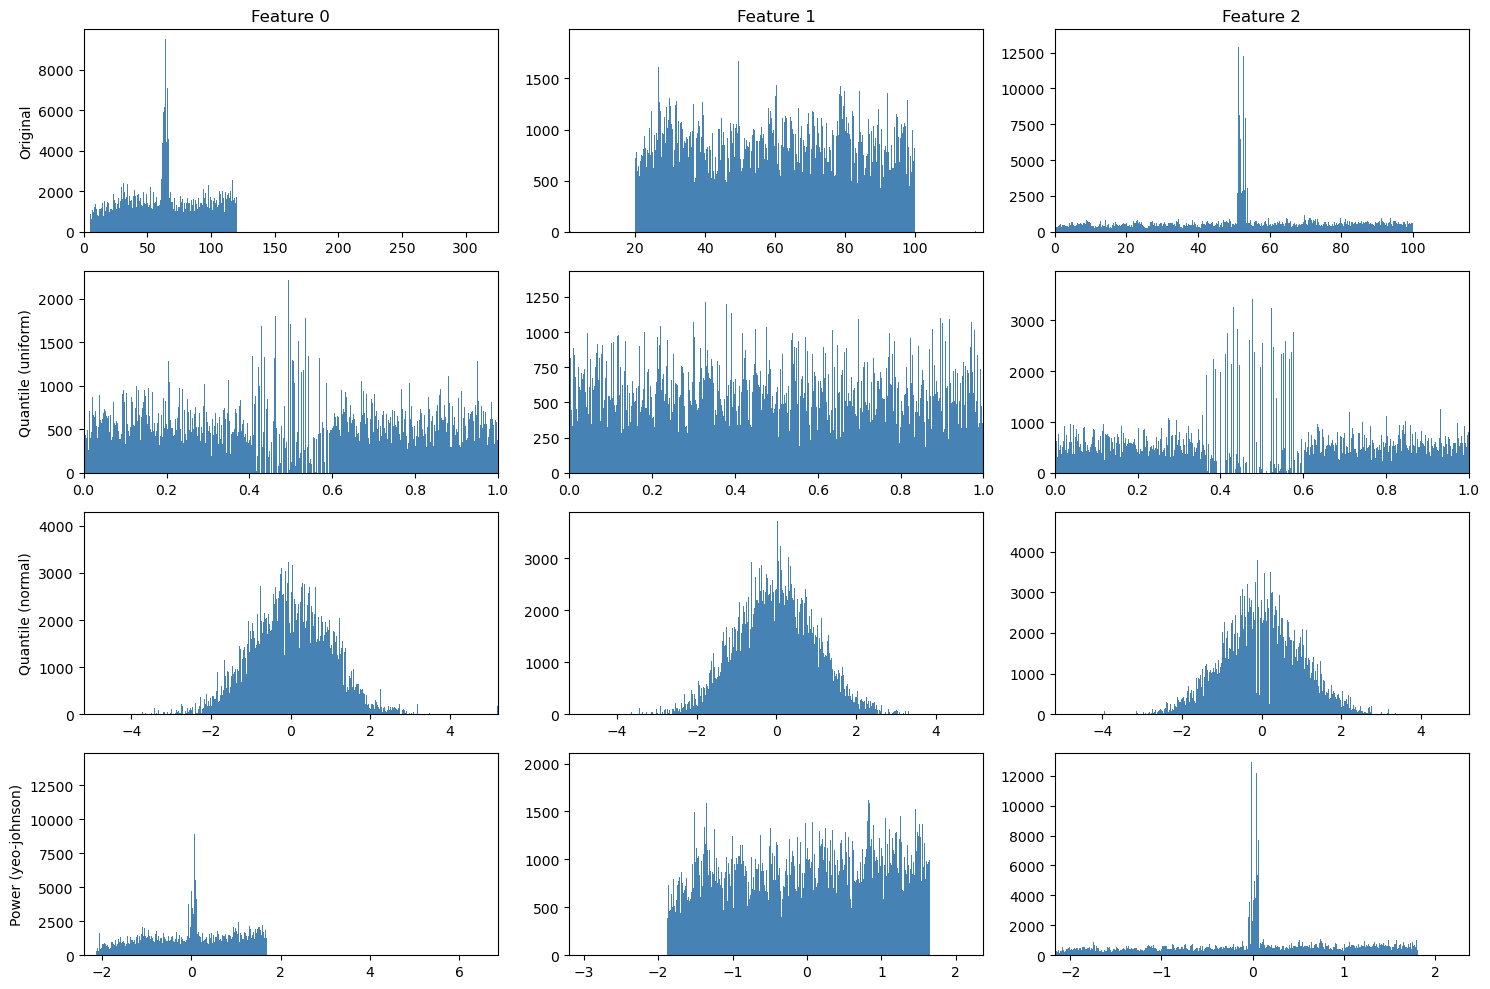

In [10]:
# Check Normalize
original_data = X_train.copy()

qt_uniform = QuantileTransformer(n_quantiles=10000, output_distribution='uniform')
qt_uniform_data = qt_uniform.fit_transform(X_train)

qt_normal = QuantileTransformer(n_quantiles=10000, output_distribution='normal')
qt_normal_data = qt_normal.fit_transform(X_train)

pt_yeo = PowerTransformer(method='yeo-johnson', standardize=True)
pt_yeo_data = pt_yeo.fit_transform(X_train)

# visualization
fig, axes = plt.subplots(4, 3, figsize=(15, 10))

datasets = [original_data, qt_uniform_data, qt_normal_data, pt_yeo_data]
titles = ['Original', 'Quantile (uniform)', 'Quantile (normal)', 'Power (yeo-johnson)']

for row in range(4):
    for col in range(3):    
        ax = axes[row, col]
        ax.hist(datasets[row][:, col], bins=1000, color='steelblue')
        ax.set_xlim(datasets[row][:, col].min(), datasets[row][:, col].max())
        if row == 0:
            ax.set_title(f'Feature {col}')
        if col == 0:
            ax.set_ylabel(titles[row])

plt.tight_layout()
plt.show()

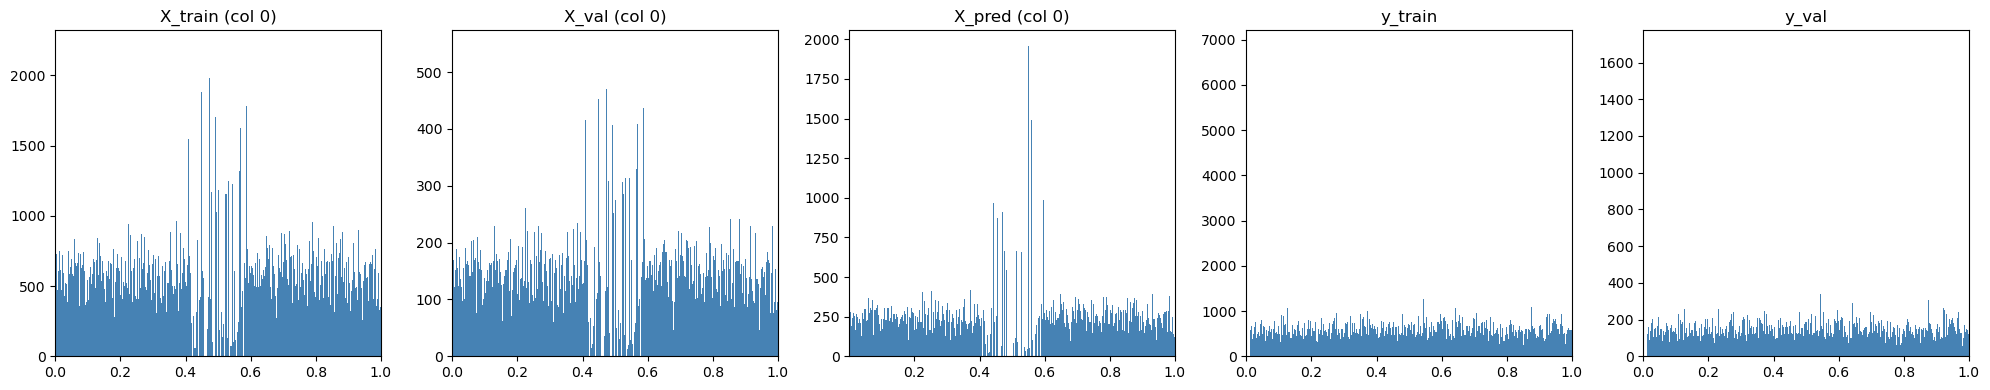

In [11]:
# Normalize
X_scaler = QuantileTransformer(
    n_quantiles=15000,
    subsample=15000,
    output_distribution='uniform',
)
y_scaler = QuantileTransformer(
    n_quantiles=15000,
    subsample=15000,
    output_distribution='uniform',
)

X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_pred_scaled = X_scaler.transform(X_pred)

y_scaler.fit(y_train.reshape(-1, 1))
y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).ravel()

# Check Normalize
data_list = [
    X_train_scaled[:, 0],
    X_val_scaled[:, 0],
    X_pred_scaled[:, 0],
    y_train_scaled,
    y_val_scaled
]

titles = ['X_train (col 0)', 'X_val (col 0)', 'X_pred (col 0)', 'y_train', 'y_val']

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    axes[i].hist(data_list[i], bins=1000, color='steelblue')
    axes[i].set_title(titles[i])
    axes[i].set_xlim(min(data_list[i]), max(data_list[i]))  # x축 범위 고정 (optional)

plt.tight_layout()
plt.show()

In [ ]:
mlp = MLPRegressor(
    solver='adam',
    activation='tanh',
    hidden_layer_sizes=[300, 300, 300],      
    max_iter=5000,                     
    early_stopping=True,    
    tol=1e-4,
    n_iter_no_change=10,
    validation_fraction=0.1,
    learning_rate='adaptive',         
    learning_rate_init=0.01,          
    alpha=0.01,
    random_state=0                      
)
mlp.fit(X_train_scaled, y_train_scaled)

y_train_pred = y_scaler.inverse_transform(mlp.predict(X_train_scaled).reshape(-1, 1)).ravel()
y_val_pred = y_scaler.inverse_transform(mlp.predict(X_val_scaled).reshape(-1, 1)).ravel()
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(np.sqrt(mean_squared_error(y_val, y_val_pred)))

13.389297947647686
13.397789472781758


In [152]:
X_scaler.fit(X)
X_scaled = X_scaler.transform(X)
X_pred_scaled = X_scaler.transform(X_pred)

y_scaler.fit(y.reshape(-1, 1))
y_scaled = y_scaler.transform(y.reshape(-1, 1)).ravel()

mlp.fit(X_scaled, y_scaled)
y_pred = y_scaler.inverse_transform(mlp.predict(X_pred_scaled).reshape(-1, 1)).ravel()
df_sub['Listening_Time_minutes'] = y_pred
df_sub.to_csv(save_path, index=False)